<a href="https://colab.research.google.com/github/bavanya/covid-19_tracker_data_mining/blob/add-time-series-dataprocessing/timesSeriesForecast/usingLSTM/dataprocessingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import torch

import os
import numpy as np
import pandas as pd
#from tqdm import tqdm
#import seaborn as sns
#from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
%matplotlib inline

In [74]:
from google.colab import drive
drive.mount('/content/drive')
path_file = '/content/drive/My Drive/Colab Notebooks/csvData.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
df = pd.read_csv(path_file)
print(df)

          date  confirmed  deaths  recovered
0    2020-1-22          0       0          0
1    2020-1-23          0       0          0
2    2020-1-24          0       0          0
3    2020-1-25          0       0          0
4    2020-1-26          0       0          0
..         ...        ...     ...        ...
217  2020-8-26    3310234   60472    2523771
218  2020-8-27    3387500   61529    2583948
219  2020-8-28    3463972   62550    2648998
220  2020-8-29    3542733   63498    2713933
221  2020-8-30    3621245   64469    2774801

[222 rows x 4 columns]


In [76]:
df.dtypes

date         object
confirmed     int64
deaths        int64
recovered     int64
dtype: object

In [77]:
df.isnull().sum().sum()

0

In [78]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.index
print(df.dtypes)

confirmed    int64
deaths       int64
recovered    int64
dtype: object


In [79]:
print(df)

            confirmed  deaths  recovered
date                                    
2020-01-22          0       0          0
2020-01-23          0       0          0
2020-01-24          0       0          0
2020-01-25          0       0          0
2020-01-26          0       0          0
...               ...     ...        ...
2020-08-26    3310234   60472    2523771
2020-08-27    3387500   61529    2583948
2020-08-28    3463972   62550    2648998
2020-08-29    3542733   63498    2713933
2020-08-30    3621245   64469    2774801

[222 rows x 3 columns]


In [80]:
df1 = df[['confirmed']]
df1 = df1.diff()
df1.loc['2020-01-22', 'confirmed'] = 0.0
df1['confirmed'] = df1['confirmed'].astype(np.int64)
print(df1.head(15))
df1.dtypes

            confirmed
date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
2020-01-27          0
2020-01-28          0
2020-01-29          0
2020-01-30          1
2020-01-31          0
2020-02-01          0
2020-02-02          1
2020-02-03          1
2020-02-04          0
2020-02-05          0


confirmed    int64
dtype: object

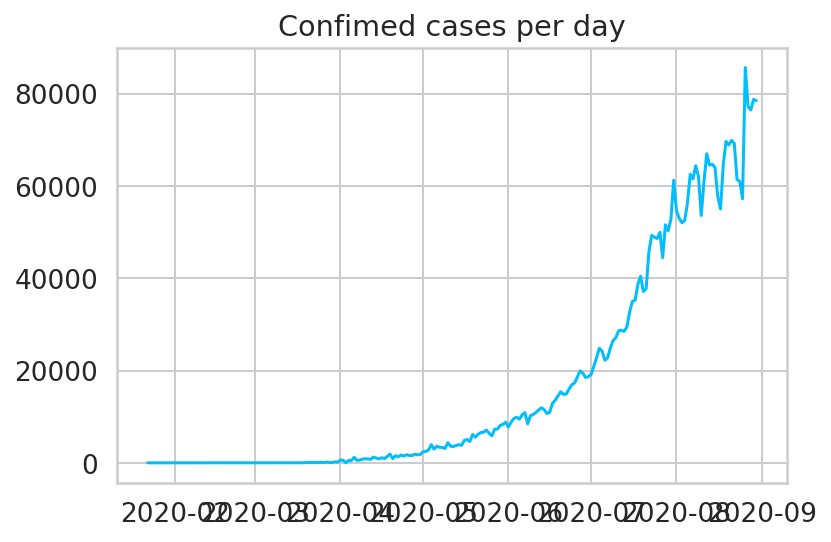

In [81]:
plt.plot(df1)
plt.title("Confimed cases per day");

In [82]:
df1.shape

(222, 1)

In [83]:
test_data_size = 44

train_data = df1[:-test_data_size]
test_data = df1[-test_data_size:]
train_data.shape

(178, 1)

In [84]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [85]:
print(train_data)

[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.83671848e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.83671848e-05]
 [2.83671848e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.67343697e-05]
 [0.00000000e+00]
 [6.52445251e-04]
 [5.67343697e-05]
 [2.83671848e-05]
 [8.51015545e-05]
 [1.41835924e-04]
 [1.13468739e-04]
 [3.68773403e-04]
 [1.70203109e-04]
 [3.12039033e-04]
 [2.55304664e-04]
 [5.67343697e-04]
 [3.12039033e-04]
 [1.70203109e-04]
 [6.524452

In [86]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [87]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [88]:
train_data[:10]

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.83671848e-05],
       [0.00000000e+00]])

In [89]:
y_train[2:]

tensor([[0.0000e+00],
        [2.8367e-05],
        [0.0000e+00],
        [0.0000e+00],
        [2.8367e-05],
        [2.8367e-05],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [5.6734e-05],
        [0.0000e+00],
        [6.5245e-04],
        [5.6734e-05],
        [2.8367e-05],
        [8.5102e-05],
        [1.4184e-04],
        [1.1347e-04],
        [3.6877e-04],
        [1.7020e-04],
        [3.1204e-04],
        [2.5530e-04],
        [5

In [90]:
X_train[2:]

tensor([[[0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00]],

        [[0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00]],

        [[0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [2.8367e-05]],

        [[0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         [2.8367e-05],
         [0.0000e+00]],

        [[0.0000e+00],
         [0.0000e+00],
         [2.8367e-05],
         [0.0000e+00],
         [0.0000e+00]],

        [[0.0000e+00],
         [2.8367e-05],
         [0.0000e+00],
         [0.0000e+00],
         [2.8367e-05]],

        [[2.8367e-05],
         [0.0000e+00],
         [0.0000e+00],
         [2.8367e-05],
         [2.8367e-05]],

        [[0.0000e+00],
         [0.0000e+00],
         [2.8367e-05],
         [2.8367e-05],
         [0.0000e+00]],

        [[0.0000e+00],
         [2.8367e-05],
         [2.8367e-

In [91]:
class CoronaVirusPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    pass
